# Modeling the HZ-1 Aerocycle using Blade Element Theory and the Doublet Panel Method

We can use Blade Element Theory and the panel method to determine the pressure and lift coefficients on a rotor blade. In this case we will be looking at a horizontal rotor on the HZ-1 Aerocycle (Figure 1). This vehicle was created during WWII and consisted of a standing "driver's seat" and two contra-rotating rotors located under the pilot. It was designed to be an ambiguous vehicle for use by ground soldiers, and was hoped to create a modernized calvary (where instead of horses, they would have Aerocycles). The project was scrapped after several crashes occurred. The reason for the crashes were due to the collision of the two rotors (investigators were unable to determine why the rotors collided).

#### Figure 1. de Lackner HZ-1 Aerocycle ####
![Image](./hz1.png)

To model and analyze the blades of the HZ-1 Aerocycle, we will use a combination of Blade Element Theory and the Doublet Panel Method. We will model the two rotating rotor blades and analyze the velocity field around them to determine the pressure and lift coefficients for the entire blade.

## Blade Element Theory

Blade element theory takes a single rotor blade and cuts it into different segments. The resulting cross sections from each segment are then analyzed separately for thrust, lift, and other parameters. In the end, the values from each segment can be integrated across the entire length of the blade to give an approximation of total thrust, lift, and so on (Figure 2).

#### Figure 2. Blade segments ####
![Image](./rotor_blade.png)

In this case, we will be using Blade Element Theory (BET) to determine the angle of attack and the local freestream velocity for each blade segment. Each segment will then be treated as an individual airfoil and the panel method can be applied to determine the coefficient of pressure and lift, with the corresponding values of freestream velocity and angle of attack. Once these parameters are solved for each "piece" of the rotor blade, we can integrate over the length of the blade to get the total values on the blade.

To solve for the angle of attack and freestream velocity of each segment, we will need to solve for the axial and angular components of velocity on each blade segment (V0 and V2, respectively) (Figure 3).

#### Figure 3. Flow vectors on a blade element
![Image](./flow_vectors.png)

We will need these components of velocity on each segment to determine the angle of attack, $\alpha\ $, and freestream velocity, $V_{\infty}\ $. In order to determine these velocities, we must solve for the induced velocity, $V_{induced}\ $. The induced velocity and climb velocity (usually given) determine the axial component of velocity for the rotor blades(Figure 4).

#### Figure 4. Axial component of velocity
![Image](./axial_comp.JPG)

Starting with an initial guess for $ V_{induced}\ $, we must then iterate through a set of force balance equations until a target convergence is met. Once we obtain the freestream velocity and angle of attack for each blade element, we can model our airfoils using the panel method.

## Panel Method

The panel method is the next step that will be implemented in the code. For each segment of the blade, the doublet panel method will be applied to determine parameters for each airfoil cross section. To model the HZ-1 aerocycle, we will set up two airfoils using panels. The first airfoil will be facing one direction, while the other will face the opposite direction and be offset in the y direction by a distance of 1 foot. To determine the velocity on each panel, we will create **A** and **b** matrices to solve for the doublet strength on each panel. Once we have this value, we can solve for different parameters such as the pressure and lift coefficients.

## Assumptions and airfoil choice

There are several essential assumptions that must be made in order to use the BET method. We assume that there are no aerodynamic interactions between blade segments, forces on the blade are determined solely by lift and drag coefficients, and the blades are ideal[1]. Since there is no detailed information on the design of the HZ-1 rotor blades, I went ahead and chose the parameters for the blade. I assumed a constant chord for each blade segment, a pitch that is a function of the radial distance, and a NACA 0012 airfoil along the length of the blade. A NACA 0012 airfoil was chosen because it was cited as being easy to construct and having a zero pitching moment coefficient[2].

## Let's code

To begin, we import the usual libraries and input parameters for our rotor blades. We also create an array **rb** to hold the location of each blade segment along the blade length. The first blade element begins at 10% of the blade length because the hub occupies some space at the beginning of the blade. The last blade element ends at 95% of the blade length to avoid calculations at the tip of the blade.

In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline
import math
numpy.set_printoptions(precision=5,linewidth=250)

In [2]:
#Blade parameters

D = 4.6                                      #diameter of rotor blades[m]
RPM = 300                                    #[rev/min]
n = RPM/60                                   #[rev/s]
omega = n*2*numpy.pi                         #[rad/s]
H = 0.0                                      #camber ratio
T = 0.12                                     #thickness ratio
rho = 1.225                                  #[kg/m^3]
R = D/2.0                                    #radius [m]
p = 1                                        #pitch
c = .1524                                    #chord [m], or 6 in  
collective = 2.0/180*numpy.pi                #collective angle
cyclic = 0.0                                 #cyclic angle
tc = 0.12*c                                  #thickness to chord ratio
N_seg = 10                                   #Number of blade segments
N_blades = 2                                 #Number of blades per rotor
rb = numpy.linspace(0.1*R, 0.95*R, N_seg)    #array with radial distances

## Balancing Forces

In order to implement the BET method, we must first define a set of equations that takes an initial guess of $V_{induced}\ $, runs it through a momentum balance, and from there, gives us a new value of $V_{induced}\ $ [3,4]. We can then iterate for values of $V_{induced}\ $ until a target convergence is met. With this value, it is then possible to find $V_{freestream}\ $ and $\alpha\ $.

Our iterative process begins with our initial guess of $V_{induced}\ $ and our geometric pitch angle, $\theta\ $. We can then go through the following set of equations to find an updated value of $V_{induced}\ $:

$$ V0 = V_{induced} + V_{climb} + V_{forward}\ cos(tilt)\ $$

$$ V2 = \omega r + V_{forward}\ sin(tilt)\ $$

$$ \phi = tan^{-1} (\frac{V0}{V2})\ $$

$$ \alpha = \theta - \phi\ $$

$$ C_{l} = 5.73\ \alpha\ $$

$$ C_{d} = 0.0002\ \alpha^{2} + 0.01\ $$

$$ V_{freestream} = \sqrt{V0^{2}+V2^{2}}\ $$

$$ \frac{dT}{dr} = \frac{1}{2 N_{segments}}\ \rho\ V_{freestream}^{2}\ N_{blades}\ c\ (C_{l}\ cos(\phi) - C_{d}\ sin(\phi))\ $$

$$ Momentum = \frac {dT}{dr} \frac {4}{\pi\ r\ \rho\ V0}\ $$

$$ V_{induced,new} = 0.9\ V_{induced} + 0.1{Momentum}\ $$

In this case, the forward velocity and climb speed were set to 0. This means that V0 was only dependent on the induced velocity and V2 on the angular velocity. The geometric pitch, $\theta\ $, is simply a sum of the collective and cyclic angles, which were set to 8 and 0 degrees, respectively. The target convergence (or minimum difference between $V_{induced}\ $ and $V_{induced,new}\ $) was set to 1E-5. The equations for lift and drag coefficients were obtained from experimental data of a NACA 0012 airfoil[5].

The iterative process was run over each blade segment, so that we end up with an array of length $N_{segments}\ $ for both the freestream velocity and angle of attack.

In [3]:
#BET iterations 
#adapted from MATLAB code in references 2 and 3

V = 0.0                            #forward velocity
tilt = 0.0/180*numpy.pi            #tilt angle
Vc = 0.0                           #climb speed
alpha = numpy.zeros_like(rb)       #array to hold AOA for each segment
V1 = numpy.zeros_like(rb)          #array to hold freestream velocity for each segment

for i in range(len(rb)):
    thetab = collective            #geometric pitch angle
    Vi = 2.0                       #initial guess for induced velocity
    check = False                  #flag to stop iterations
    target = 1e-5                  #target convergence
    iterations = 0                 #track number of iterations
    
    while check == False:
        V0 = Vi +Vc +V*numpy.sin(tilt)
        V2 = omega*rb[i] + V*numpy.cos(tilt)
        phi = numpy.arctan2(V0,V2)
        al = thetab-phi
        cl = 5.73*al
        cd = 0.0002*(al)**2 + 0.01
        Vlocal = numpy.sqrt(V0**2+V2**2)
        DtDr = 0.5*rho*Vlocal**2*N_blades*c*(cl*numpy.cos(phi)-cd*numpy.sin(phi))/N_seg
        mom1 = DtDr/(numpy.pi/4.0*rb[i]*rho*V0)
        Vinew = 0.9*Vi + 0.1*mom1
        if Vinew <0:
            Vinew=0
        
        iterations += 1
        
        if numpy.absolute(Vinew-Vi) < target:
            check = True
            print('end segment {}, number of iterations: {}'.format(i,iterations)) 
        
        Vi = Vinew
        if iterations > 20000:
            break          
        
    V0 = Vi+Vc+V*numpy.sin(tilt)
    V2 = omega*rb[i]+V*numpy.cos(tilt)
    V1[i] = numpy.sqrt(V0**2+V2**2)
    phi = float(numpy.arctan2(V0,V2))
    alpha[i] = thetab-numpy.arctan2(V0,V2)

end segment 0, number of iterations: 26
end segment 1, number of iterations: 9
end segment 2, number of iterations: 13
end segment 3, number of iterations: 15
end segment 4, number of iterations: 16
end segment 5, number of iterations: 18
end segment 6, number of iterations: 19
end segment 7, number of iterations: 19
end segment 8, number of iterations: 20
end segment 9, number of iterations: 20


We can check to see that our $ V_{\infty}\ $ and $\alpha\ $ arrays are filled and have acceptable values:

In [4]:
print('freestream velocity {}'.format(V1))
print('alpha {}'.format(numpy.degrees(alpha)))

freestream velocity [  7.22952  14.05665  20.88329  27.70958  34.5356   41.3614   48.18704  55.01253  61.83791  68.66319]
alpha [ 0.12957  0.22445  0.30327  0.37041  0.42868  0.48001  0.52575  0.5669   0.60424  0.63835]


These values look to be consistent. We know that the angular velocity increases as our radial distance along the blade increases; this means that our freestream velocity will be increasing as we move further away from the hub. Similarly, we know that due to the blade pitch, the angle of attack should be increasing as the radial distance increases (meaning that the blade is more angled at the tip than at the root).

## Creating the Panels

Now that we have our freestream velocity and angle of attack for each blade segment, we can create our blades' airfoils using the panel method, and associate each set of panels with the appropriate values of $ V_{\infty}\ $ and $\alpha\ $. Since we are creating two airfoils that point in opposite directions, we will need to create two Panel classes to account for the sign change in the x-direction. This simply involves switching the a and b components of x and y for the backwards-facing airfoil. Each panel class will contain equations to find the endpoints, collocation points, angle between the horizontal, normal unit vector, and tangential unit vector for each panel.

In [5]:
class Panel:
    """Contains information related to a panel."""
    def __init__(self, xa, ya, xb, yb):
        """Initializes the panels that face the positive x-direction.
        
        Arguments
        ---------
        xa, ya -- coordinates of the first end-point of the panel.
        xb, yb -- coordinates of the second end-point of the panel.
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2            # collocation point (center-point)
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2)     # length of the panel
        
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.:
            self.beta = math.acos((yb-ya)/self.length)
        elif xb-xa > 0.:
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)
        
        self.n = [ math.cos(self.beta), math.sin(self.beta)]
        self.t = [-math.sin(self.beta), math.cos(self.beta)]
        
        self.xd = [0,0]                             #unit vector perpendicular to freestream velocity
        self.yd = [0,0]                             #unit vector parallel to freestream velocity
        
        self.kappa = 1                              # doublet strength
        self.vt = 0                                 # tangential velocity
        self.cp = 0                                 # pressure coefficient

In [6]:
class Panelb:
    """Contains information related to a panel."""
    def __init__(self, xb, yb, xa, ya):      #xa, ya, xb, yb inputs are switched
        """Initializes the panels that face the negative x-direction.
        
        Arguments
        ---------
        xa, ya -- coordinates of the first end-point of the panel.
        xb, yb -- coordinates of the second end-point of the panel.
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2            # collocation point (center-point)
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2)     # length of the panel
        
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.:
            self.beta = math.acos((yb-ya)/self.length)         #angle between x-axis and panel's normal
            
        elif xb-xa > 0.:
            self.beta = math.acos(-(yb-ya)/self.length)+math.pi
            
        
        self.n = [ math.cos(self.beta), math.sin(self.beta)]
        self.t = [-math.sin(self.beta), math.cos(self.beta)]
        
        self.xd = [0,0]                             #unit vector perpendicular to freestream velocity
        self.yd = [0,0]                             #unit vector parallel to freestream velocity
        
        self.kappa = 1                              # doublet strength
        self.vt = 0                                 # tangential velocity
        self.cp = 0                                 # pressure coefficientbb

Each of the blade elements are the same; the only difference is their location along the blade. We can go ahead and create two arrays that hold $N_{segments}\ $-sets of panels; the first array will hold the forward-facing-airfoil panels, while the second will hold the backwards-facing-airfoil panels. The endpoints for the backwards-facing-airfoil panels will be a little different. As mentioned before, the x-values will be switched around, and to set the distance between the two contra-rotating blades, we will add a 1 foot (0.3 m) offset to the complex component of the Joukowski transformation. Once the airfoil panels are plotted, the top panels will represent the backwards-facing airfoil, and the bottom will be the forwards-facing airfoil.

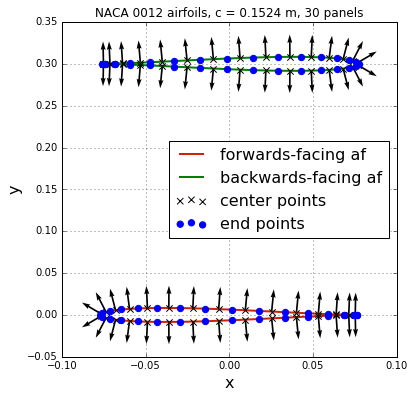

In [7]:
# plot NACA 0012 airfoil
N_panels = 30                                             # number of panels desired

T = 0.12
H = 0
c = 0.1524  #[m] = 6 in
a = c/4
r = (0.25+T/(3*math.sqrt(3)))*c                           # circle radius
zeta_c = -4*a/(3*math.sqrt(3))*T + 1j*2*a*H               # circle center
theta = numpy.linspace(0, 2*math.pi, N_panels+1)          # theta endpoints of panels
zeta = r*numpy.exp(1j*theta)                              # endpoints of circle surface panels
zeta2 = r*numpy.exp(1j*theta)
z_ends = (zeta+zeta_c) + a**2/(zeta+zeta_c)               # endpoints of airfoil surface panels
z_ends2 = (zeta2+zeta_c) + a**2/(zeta2+zeta_c)+0.3j       # add 1 ft offset from other airfoil
x_ends,  y_ends = z_ends.real, z_ends.imag
x_ends2, y_ends2 = -z_ends2.real, z_ends2.imag            #turn airfoil in other direction by making x negative

# define the panels
panelsa = numpy.empty((N_seg,N_panels+1), dtype=object)           #panels array for forward facing airfoil (a)
panelsb = numpy.empty((N_seg,N_panels+1), dtype=object)           #panels array for backward facing and offset airfoil (b)

for s in range(N_seg):
    for i in range(N_panels):
        panelsa[s,i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
        panelsb[s,i] = Panelb(x_ends2[i], y_ends2[i], x_ends2[i+1], y_ends2[i+1])
    panelsa[s,-1] = Panel(x_ends[0], y_ends[0], x_ends[0]+1000, y_ends[0])
    panelsb[s,-1] = Panelb(x_ends2[0], y_ends2[0], x_ends2[0]-1000, y_ends2[0])

# plot the panels
size = 6
pyplot.figure(figsize=(size, size))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_ends, y_ends, color='#CD2305', linestyle='-', linewidth=2,label='forwards-facing af')
pyplot.plot(x_ends2,y_ends2, color='g', linestyle='-', linewidth=2,label='backwards-facing af')
pyplot.scatter([p.xc for p in panelsa[1]], [p.yc for p in panelsa[1]], color='k', marker='x', s=40, zorder=3,label='center points')
pyplot.scatter([p.xa for p in panelsa[1]], [p.ya for p in panelsa[1]], color='b', marker='o', s=40, zorder=3,label='end points')
pyplot.scatter([p.xc for p in panelsb[1]], [p.yc for p in panelsb[1]], color='k', marker='x', s=40, zorder=3)
pyplot.scatter([p.xa for p in panelsb[1]], [p.ya for p in panelsb[1]], color='b', marker='o', s=40, zorder=3)
pyplot.quiver([p.xc for p in panelsa[1]], [p.yc for p in panelsa[1]], [p.n[0] for p in panelsa[1]], [p.n[1] for p in panelsa[1]],
              scale=15, width=0.005)
pyplot.quiver([p.xc for p in panelsb[1]], [p.yc for p in panelsb[1]], [p.n[0] for p in panelsb[1]], [p.n[1] for p in panelsb[1]],
              scale=15, width=0.005)
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-0.1, 0.1)
pyplot.title('NACA 0012 airfoils, c = {} m, {} panels'.format(c,N_panels));

Now that we have our panels created and values for the angle of attack, we can go ahead and update the values of the unit vectors that are perpendicular to the freestream. We can check that these are correct by plotting them on a set of panels.

In [8]:
# create unit vectors perpendicular to freestream
def unit_vectors(panelsa,panelsb):
    
    for s in range(N_seg):
        for i, panels in enumerate(panelsa[s,:]):
            panels.xd = [-numpy.sin(alpha[s]),numpy.cos(alpha[s])]
        for i, panels in enumerate(panelsb[s,:]):
            panels.xd = [-numpy.sin(alpha[s]),numpy.cos(alpha[s])]

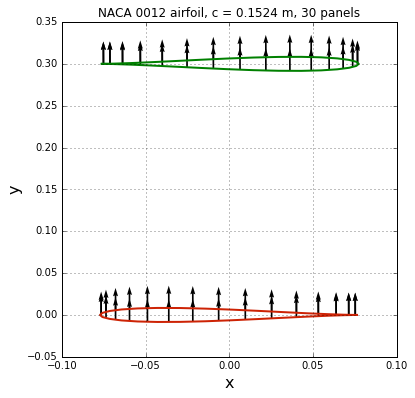

In [9]:
unit_vectors(panelsa,panelsb)

# plot the panels and unit vectors perpendicular to the freestream
size = 6
pyplot.figure(figsize=(size, size))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_ends, y_ends, color='#CD2305', linestyle='-', linewidth=2)
pyplot.plot(x_ends2,y_ends2,color ='g', linestyle='-', linewidth=2)
pyplot.quiver([p.xc for p in panelsa[1]], [p.yc for p in panelsa[1]], [p.xd[0] for p in panelsa[0,:]], [p.xd[1] for p in panelsa[0]],
              scale=15, width=0.005)
pyplot.quiver([p.xc for p in panelsb[1]], [p.yc for p in panelsb[1]], [p.xd[0] for p in panelsb[1]], [p.xd[1] for p in panelsb[1]],
              scale=15, width=0.005)
pyplot.xlim(-0.1, 0.1)
pyplot.title('NACA 0012 airfoil, c = {} m, {} panels'.format(c,N_panels));

Great, we successfully created the two sets of panels to represent the contra-rotating blades. Next, we can define some functions to solve for the induced velocities, the **A** and **b** matrices, the doublet strength, the tangential velocities, and the pressure coefficient for each set of panels.

In [10]:
def get_doublet_panel_velocity(p,x,y):
    """Evaluates the velocity components induced at coordinates (x,y) by a panel p.
    
    Arguments
    ---------
    p -- panel from which the velocity is induced
    x -- x-coordinate in global frame
    y -- y-coordinate in global frame
    
    Returns
    -------
    (u,v)-components of velocity at (x,y)
    """
    
    x_p =  math.sin(p.beta)*(x-p.xb) - math.cos(p.beta)*(y-p.yb)
    y_p =  math.cos(p.beta)*(x-p.xb) + math.sin(p.beta)*(y-p.yb)
    
    u_p = -p.kappa/(2*math.pi)*(y_p/(x_p**2+y_p**2) - y_p/((x_p-p.length)**2+y_p**2))
    v_p =  p.kappa/(2*math.pi)*(x_p/(x_p**2+y_p**2) - (x_p-p.length)/((x_p-p.length)**2+y_p**2))
    
    u =  math.sin(p.beta)*u_p + math.cos(p.beta)*v_p
    v = -math.cos(p.beta)*u_p + math.sin(p.beta)*v_p
    
    return u, v

The **A** matrix will be organized as shown in figure 5, where each quadrant of the matrix represent the effects of one set of airfoil panels on itself or on the other set of airfoil panels. Since all of the airfoils are the same (NACA 0012 and same chord), the **A** matrix will be the same for each set of panels. However, since the freestream velocity, $V_{\infty}\ $, and angle of attack, $\alpha\ $, are different for each blade segment, we need to create our matrix b such that it creates $N_{segments}\ $ of **b** matrices. Figure 6 shows a physical representation of what this looks like, where each rectangle is a **b** matrix for each blade element.

#### Figure 5. Division of A matrix
![Image](./A_matrix.JPG)

#### Figure 6. Creation of b matrix 
![Image](./b_matrix.JPG)

In [11]:
# compute the influence coefficient matrix
def matrix_norm(N_panels,N_seg,panelsa,panelsb,V1,alpha):
    A = numpy.zeros((2*N_panels+2, 2*N_panels+2), dtype=float)
    b = numpy.zeros((N_seg,2*N_panels+2, 1), dtype=float)
    for s in range(N_seg):
        for i, p_i in enumerate(panelsa[s,0:N_panels]):
            for j, p_j in enumerate(panelsa[s,:]):
                A[i,j] = numpy.dot(get_doublet_panel_velocity(p_j, p_i.xc, p_i.yc), p_i.n)
                if i == j:
                    A[i,j] *= 1.001
            for j, p_j in enumerate(panelsb[s,:]):
                A[i,j+N_panels+1] = numpy.dot(get_doublet_panel_velocity(p_j, p_i.xc, p_i.yc), p_i.n)
                
        for i, p_i in enumerate(panelsb[s,0:N_panels]):
            for j, p_j in enumerate(panelsa[s,:]):
                A[i+N_panels+1,j] = numpy.dot(get_doublet_panel_velocity(p_j, p_i.xc, p_i.yc), p_i.n)
            for j, p_j in enumerate(panelsb[s,:]):
                A[i+N_panels+1,j+N_panels+1] = numpy.dot(get_doublet_panel_velocity(p_j, p_i.xc, p_i.yc), p_i.n)
                if i == j:
                    A[i+N_panels+1,j+N_panels+1] *= 1.001
                
        A[N_panels,0] = 1
        A[N_panels,N_panels-1] = -1
        A[N_panels,N_panels] = -1
        A[-1,N_panels+1] = 1
        A[-1,-2] = -1
        A[-1,-1] = -1

        # compute the RHS of the linear system
        for i, p_i in enumerate(panelsa[s,0:N_panels]):  
            b[s,i,0] = numpy.dot(numpy.array([V1[s]*math.cos(alpha[s]), V1[s]*math.sin(alpha[s])]), p_i.n)
        for i, p_i in enumerate(panelsb[s,0:N_panels]):   
            b[s,i+N_panels+1,0] = numpy.dot(numpy.array([V1[s]*math.cos(alpha[s]), V1[s]*math.sin(alpha[s])]), p_i.n)
        
    return A,b

The array which holds values of $\kappa\ $ will have the same dimensions as matrix **b**. The top half of $\kappa\ $ will hold the values for the forward-facing-airfoil panels, and the bottom half will hold the values for the backward-facing-airfoil panels.

In [12]:
# solves the linear system
def find_kap(A,b,panelsa,panelsb,N_seg):
    kappa = numpy.zeros((N_seg,2*N_panels+2,1),dtype=float)
    for s in range(N_seg):
        kappa[s,:,0] = numpy.linalg.solve(A, b[s,:,0])

        for i, panels in enumerate(panelsa[s,:]):
            panels.kappa = float(kappa[s,i,0])                    #top half of kappa are the values for airfoil a
        for i, panels in enumerate(panelsb[s,:]):
            panels.kappa = float(kappa[s,i+N_panels+1,0])         #bottom half of kappa are the values for airfoil b
    return kappa

In [13]:
A,b = matrix_norm(N_panels,N_seg,panelsa,panelsb,V1,alpha)
kappa = find_kap(A,b,panelsa,panelsb,N_seg)

The tangential component of velocity is found as was given in the HW 11 solution, except that we now have to take into account the effects of the airfoils on each other. Below is a function that will calculate the tangential velocity and pressure coefficient for each airfoil at each segment. It will update the values for **vt** and **cp** in the Panel class for each airfoil, so that we can later use those values to find the lift coefficient.

In [14]:
for s in range(N_seg):
    for i, p_i in enumerate(panelsa[s,0:N_panels]):
        vta = numpy.array([0])
        for j, p_j in enumerate(panelsa[s,:]):
            if i != j:
                vta = vta + numpy.dot(get_doublet_panel_velocity(p_j, p_i.xc, p_i.yc), p_i.t)
        if i == 0:
            R = math.sqrt((panelsa[s,1].xc-panelsa[s,0].xc)**2 + (panelsa[s,1].yc-panelsa[s,0].yc)**2)
            vta = vta - 0.5*(panelsa[s,1].kappa-panelsa[s,0].kappa)/R
        elif i == N_panels-1:
            R = math.sqrt((panelsa[s,N_panels-1].xc-panelsa[s,N_panels-2].xc)**2 + (panelsa[s,N_panels-1].yc-panelsa[s,N_panels-2].yc)**2)
            vta = vta - 0.5*(panelsa[s,N_panels-1].kappa-panelsa[s,N_panels-2].kappa)/R
        else:
            R = math.sqrt((panelsa[s,i+1].xc-panelsa[s,i-1].xc)**2 + (panelsa[s,i+1].yc-panelsa[s,i-1].yc)**2)
            vta = vta - 0.5*(panelsa[s,i+1].kappa-panelsa[s,i-1].kappa)/R
            
        for j, p_j in enumerate(panelsb[s,:]):
            if i != 0 and i!= N_panels-1:
                vta = vta + numpy.dot(get_doublet_panel_velocity(p_j, p_i.xc, p_i.yc), p_i.t)
        
        vta = vta + numpy.dot(numpy.array([V1[s]*math.cos(alpha[s]), V1[s]*math.sin(alpha[s])]), p_i.t)
        p_i.vt = float(vta)
        p_i.cp = 1.0 - (p_i.vt/V1[s])**2
        
    for i, p_i in enumerate(panelsb[s,0:N_panels]):
        vtb = numpy.array([0])
        for j, p_j in enumerate(panelsb[s,:]):
            if i != j:
                vtb = vtb + numpy.dot(get_doublet_panel_velocity(p_j, p_i.xc, p_i.yc), p_i.t)
        if i == 0:
            R = math.sqrt((panelsb[s,1].xc-panelsb[s,0].xc)**2 + (panelsb[s,1].yc-panelsb[s,0].yc)**2)
            vtb = vtb - 0.5*(panelsb[s,1].kappa-panelsb[s,0].kappa)/R
        elif i == N_panels-1:
            R = math.sqrt((panelsb[s,N_panels-1].xc-panelsb[s,N_panels-2].xc)**2 + (panelsb[s,N_panels-1].yc-panelsb[s,N_panels-2].yc)**2)
            vtb = vtb - 0.5*(panelsb[s,N_panels-1].kappa-panelsa[s,N_panels-2].kappa)/R
        else:
            R = math.sqrt((panelsb[s,i+1].xc-panelsb[s,i-1].xc)**2 + (panelsb[s,i+1].yc-panelsb[s,i-1].yc)**2)
            vtb = vtb - 0.5*(panelsb[s,i+1].kappa-panelsb[s,i-1].kappa)/R
            
        for j, p_j in enumerate(panelsa[s,:]):
            if i != 0 and i!= N_panels-1:
                vtb = vtb + numpy.dot(get_doublet_panel_velocity(p_j, p_i.xc, p_i.yc), p_i.t)
        
        vtb = vtb + numpy.dot(numpy.array([V1[s]*math.cos(alpha[s]), V1[s]*math.sin(alpha[s])]), p_i.t)
        p_i.vt = float(vtb)
        p_i.cp = 1.0 - (p_i.vt/V1[s])**2


Now we can check to see whether our values of the pressure coefficient are correct, by comparing them to their theoretical values. We will just check the first lower blade segment.

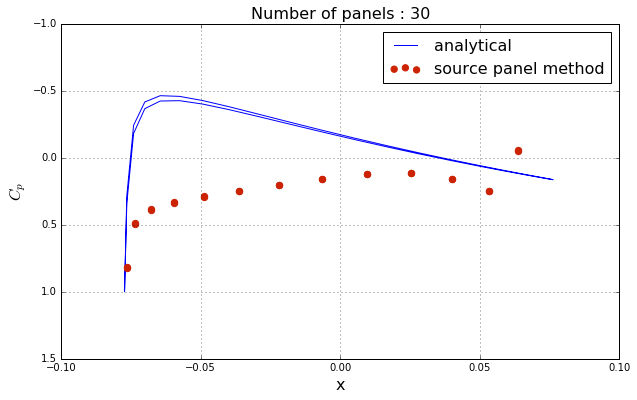

In [15]:
# create surface of airfoil for analytical solution
thetaa = numpy.linspace(0.01, 2*math.pi-0.01, 41)      # theta coordinates
zeta = r*numpy.exp(1j*thetaa)                          # circle coordinates
z = (zeta+zeta_c) + a**2/(zeta+zeta_c)                # airfoil coordinates

# flow parameters
kapp = 2*math.pi*V1[0]*r**2                            # doublet strength for circle with radius r
Gam = 4*math.pi*r*V1[0]*numpy.sin(alpha[0]+2*H)      # vortex strength

# compute the complex velocity on the surface
w = V1[0]- kapp/(2*math.pi)/zeta**2 + 1j*Gam/(2*math.pi)/zeta
zeta = zeta*numpy.exp(1j*alpha[0])

# Joukowski transformation
w = w/(1 - a**2/(zeta+zeta_c)**2)
cp_analytical = 1 - numpy.abs(w)**2/V1[0]**2

# plots the surface pressure coefficient
pyplot.figure(figsize=(10, 6))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot(z.real, cp_analytical, color='b', linestyle='-', linewidth=1, zorder=1)
pyplot.scatter([p.xc for p in panelsa[0,0:N_panels]], [p.cp for p in panelsa[0,0:N_panels]], color='#CD2305', s=40, zorder=2)
pyplot.title('Number of panels : %d' % N_panels, fontsize=16)
pyplot.legend(['analytical', 'source panel method'], loc='best', prop={'size':16})
#pyplot.xlim(-0.6, 0.6)
pyplot.ylim(-1, 1.5)
pyplot.gca().invert_yaxis();

(The values for the numerically calculated values of $C_{p}\ $ are no where near the theoretical. This may be due to an error or typo in the calculations for the tangential velocity. The cell that calculates the tangential velocity and coefficient of pressure needs to be corrected.)

Once the values are similar, we can assume that the coefficient of pressure was calculated correctly, and we can move on to obtaining the lift coefficient from each set of panels. Then, once we have a lift coefficient for each panel, we can integrate them over the length of the blade to get a total lift coefficient!

To calculate the lift coefficient, we can use the following equation [6]:

$$ C_{l} = -\oint_S C_{p} \hat{n} \ \cdot\ \hat{l} \,ds\ $$

We will create a function that will calculate the lift coefficient for each airfoil,  at each segment.

Then, to find the lift coefficient over the whole blade, we can use a Riemann sum to integrate the values of $ C_{l}\ $ for each segment, and divide by the overall blade length. Figure 7 shows a physical representation of the Riemann sum over the blade length.

#### Figure 7. Integration over the length of the blade
![Image](./riemann.JPG)


Since our values for the coefficient of pressure are incorrect, the values for the lift coefficient will also be incorrect, but the steps for procuring the blade's overall lift coefficient will be outlined below.

In [16]:
def lift_coeff(panelsa,panelsb):
    cla = numpy.zeros((N_seg,1),dtype=float)            #holds overall lift coefficient for airfoil a, at each segment
    clb = numpy.zeros((N_seg,1),dtype=float)            #holds overall lift coefficient for airfoil b, at each segment
    for s in range(N_seg):
        
        for i, p in enumerate(panelsa[s,:]):
            cla[s] = cla[s] + numpy.dot(p.n,p.xd)*p.length*(-p.cp)
            
        for i, p in enumerate(panelsb[s,:]):
            clb[s] = clb[s] + numpy.dot(p.n,p.xd)*p.length*(-p.cp)
            
    return cla,clb

In [17]:
cla,clb = lift_coeff(panelsa,panelsb)

In [18]:
def riemann_sum(cla,clb):
    dr = rb[1]-rb[0]
    cl_tot_a = 0
    cl_tot_b = 0
    for s in range(N_seg):
        cl_tot_a += cla[s]*dr/R
        cl_tot_b += clb[s]*dr/R
        
    return cl_tot_a,cl_tot_b

In [19]:
cl_tot_a,cl_tot_b = riemann_sum(cla,clb)
cl_tot_a,cl_tot_b

(array([ 1.00741]), array([-6423.90504]))

The total $C_{l}\  $ for the forwards-facing blade are questionable, and those for the backwards-facing blade are completely wrong. Again, this goes back to calculating the tangential velocity incorrectly.

The HZ-1 Aerocycle was a unique rotorcraft that still piques the interest of flying enthusiasts. Although an accurate value for the lift coefficient was not found, the steps are outlined for finding the total lift coefficient on the blade.

![Image](./hz1.JPG)

# Improvements

Obviously, the cell that computes the tangential velocity and pressure coefficient must be fixed so that the correct values are output. It would also be good practice to check that the **A** and **b** matrices are outputting a reasonable answer, to ensure that $\kappa\ $ is also being calculated correctly. A theoretical lift coefficient for a rotor blade is needed to compare to the total calculated lift coefficient; it would be best to find a rotorcraft that has a similar rotor as the HZ-1 Aerocycle.

Many assumptions were made in the above analysis. Namely, when using the BET method, I assumed that there was a constant blade chord, a linear pitch along the blade, no aerodynamic interactions between blade segments, the forces on the blade depended solely on the lift coefficient, and no tip loss (ideal blade).

For a real rotor blade, there will be tip losses. Real rotor blades also tend to have a more complex geometry. Improvements that could be made for this analysis include:

- input more complex blade shape
- correction factor for tip loss
- varying flight conditions
- introduce ground effects (mirroring panels)
- include code in the BET method to calculate lift (to have something to compare the panel method lift with)

In general, the method outlined above can also be applied to other rotor blades with different parameters.

# References

[1] https://community.dur.ac.uk/g.l.ingram/download/wind_turbine_design.pdf

[2] http://naca.central.cranfield.ac.uk/reports/1949/naca-tn-1812.pdf

[3] http://s6.aeromech.usyd.edu.au/aerodynamics/index.php/sample-page/propulsion/blade-element-rotor-theory/

[4] http://s6.aeromech.usyd.edu.au/aerodynamics/index.php/sample-page/propulsion/blade-element-propeller-theory/

[5] http://naca.central.cranfield.ac.uk/reports/1937/naca-report-586.pdf

[6] http://www.mathematica-journal.com/issue/v10i4/contents/PanelMethods/PanelMethods.pdf

https://en.wikipedia.org/wiki/De_Lackner_HZ-1_Aerocycle

http://www.aerospaceweb.org/question/airfoils/q0259c.shtml

http://www.pprune.org/rotorheads/254584-typical-rotor-rpm.html